# Traditional Time Series Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
# import statsmodels.api as sm #cannot find factorial
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import acf, pacf 
from datetime import datetime as dt
%matplotlib inline
from matplotlib.pylab import rcParams
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
rcParams['figure.figsize'] = 15, 6

#### Create main dataframe

In [2]:
!ls -l

total 4960
-rw-r--r--  1 bowhead  staff  437670 Dec 22 18:28 Traditional Time Series - ARIMA VAR 120118.ipynb
-rw-r--r--  1 bowhead  staff  295874 Dec 22 17:01 btc_lstm_final_v1.ipynb
-rw-r--r--  1 bowhead  staff  349991 Dec 22 16:11 btc_lstm_final_v2.ipynb
-rw-r--r--  1 bowhead  staff  245527 Dec 22 16:11 btc_rnn_lstm.ipynb
-rw-r--r--  1 bowhead  staff    1130 Dec 22 16:11 btc_test.csv
-rw-r--r--  1 bowhead  staff  120205 Dec 22 16:11 btc_training.csv
-rw-r--r--  1 bowhead  staff  928189 Dec 22 16:11 data_experiments.ipynb
-rw-r--r--  1 bowhead  staff  143847 Dec 22 17:03 full_series.csv


In [3]:
#Import, sort and filter, describe
df = pd.read_csv('full_series.csv',index_col="Date",parse_dates=True)
df = df.sort_index(ascending = True)
df = df[(df.index >= '2017-01-01')] # remove tail (where there is little predictive information)
print('\n Data Types:')
print(df.dtypes)
print(df.head(2))
print("")
print(len(df))


 Data Types:
Price           float64
Open            float64
High            float64
Low             float64
Vol2            float64
Change %         object
ARIMA(0,1,2)    float64
ARIMA(0,1,1)    float64
ARIMA(1,2,1)    float64
ARIMA(0,1,3)    float64
VAR(2)          float64
VAR(4)          float64
dtype: object
             Price   Open    High    Low     Vol2 Change %  ARIMA(0,1,2)  \
Date                                                                       
2017-01-01   995.4  963.4  1001.6  956.1  41150.0    3.33%           NaN   
2017-01-02  1017.0  995.4  1031.7  990.2  64950.0    2.17%           NaN   

            ARIMA(0,1,1)  ARIMA(1,2,1)  ARIMA(0,1,3)  VAR(2)  VAR(4)  
Date                                                                  
2017-01-01           NaN           NaN           NaN     NaN     NaN  
2017-01-02           NaN           NaN           NaN     NaN     NaN  

848


#### Data Prep for Univariate Modeling

In [4]:
#Create univariate time series df
ts = df[['Price', 'Open']]
ts = ts.drop(['Open'], axis = 1)
print(ts.head(24)) #Trades on weekends

             Price
Date              
2017-01-01   995.4
2017-01-02  1017.0
2017-01-03  1033.3
2017-01-04  1135.4
2017-01-05   989.3
2017-01-06   886.2
2017-01-07   888.9
2017-01-08   900.9
2017-01-09   899.8
2017-01-10   904.4
2017-01-11   785.4
2017-01-12   810.1
2017-01-13   824.8
2017-01-14   819.6
2017-01-15   821.2
2017-01-16   827.3
2017-01-17   899.7
2017-01-18   872.0
2017-01-19   895.2
2017-01-20   892.9
2017-01-21   919.8
2017-01-22   918.8
2017-01-23   921.5
2017-01-24   893.8


In [5]:
print(ts.tail(24))

             Price
Date              
2019-04-05  5010.2
2019-04-06  5046.2
2019-04-07  5173.6
2019-04-08  5245.2
2019-04-09  5158.4
2019-04-10  5307.8
2019-04-11  5022.6
2019-04-12  5054.2
2019-04-13  5051.8
2019-04-14  5134.8
2019-04-15     NaN
2019-04-16     NaN
2019-04-17     NaN
2019-04-18     NaN
2019-04-19     NaN
2019-04-20     NaN
2019-04-21     NaN
2019-04-22     NaN
2019-04-23     NaN
2019-04-24     NaN
2019-04-25     NaN
2019-04-26     NaN
2019-04-27     NaN
2019-04-28     NaN


In [6]:
ts = ts.dropna()
print(ts)


             Price
Date              
2017-01-01   995.4
2017-01-02  1017.0
2017-01-03  1033.3
2017-01-04  1135.4
2017-01-05   989.3
2017-01-06   886.2
2017-01-07   888.9
2017-01-08   900.9
2017-01-09   899.8
2017-01-10   904.4
2017-01-11   785.4
2017-01-12   810.1
2017-01-13   824.8
2017-01-14   819.6
2017-01-15   821.2
2017-01-16   827.3
2017-01-17   899.7
2017-01-18   872.0
2017-01-19   895.2
2017-01-20   892.9
2017-01-21   919.8
2017-01-22   918.8
2017-01-23   921.5
2017-01-24   893.8
2017-01-25   894.4
2017-01-26   915.6
2017-01-27   918.0
2017-01-28   918.5
2017-01-29   914.5
2017-01-30   920.7
...            ...
2019-03-16  4006.4
2019-03-17  3981.5
2019-03-18  3990.2
2019-03-19  4017.0
2019-03-20  4041.2
2019-03-21  3982.2
2019-03-22  3990.4
2019-03-23  4002.5
2019-03-24  3994.7
2019-03-25  3937.0
2019-03-26  3942.8
2019-03-27  4041.7
2019-03-28  4025.6
2019-03-29  4102.2
2019-03-30  4111.8
2019-03-31  4102.3
2019-04-01  4145.1
2019-04-02  4859.3
2019-04-03  4968.7
2019-04-04  

#### Checking for stationarity

<AxesSubplot:xlabel='Date'>

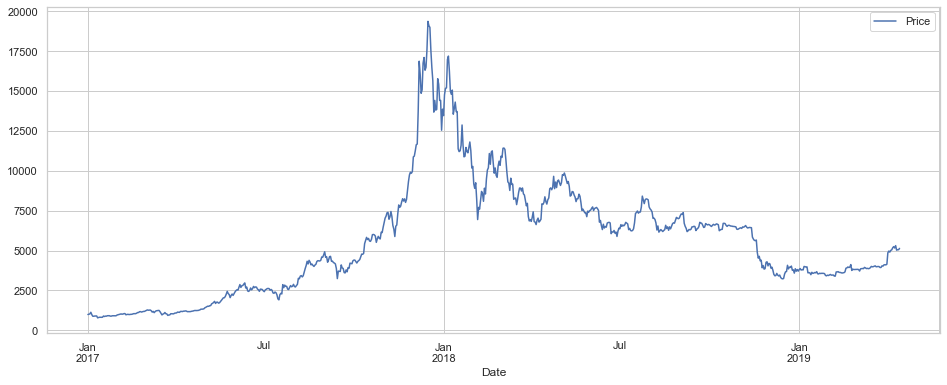

In [7]:
ts.plot(figsize=(16,6))

In [8]:
#Determine spliiting point based on: 

ts = ts[(ts.index >= '2018-12-01')]
print(ts.head(1))

             Price
Date              
2018-12-01  4196.2


#### Function for testing stationarity
Dickey and Fuller (1979) developed a procedure for testing whether a variable has a unit root or,
equivalently, that the variable follows a random walk. The null hypothesis is
always that the variable has a unit root. They differ in whether the null hypothesis includes a drift
term and whether the regression used to obtain the test statistic includes a constant term and time
trend. Source: https://www.stata.com/manuals13/tsdfuller.pdf

In [9]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(14).mean() #Trades on weekends
    rolstd = timeseries.rolling(14).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Std Dev')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Dickey-Fuller Test Results:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [10]:
ts['Price']

Date
2018-12-01    4196.2
2018-12-02    4160.4
2018-12-03    3897.8
2018-12-04    3958.5
2018-12-05    3771.6
2018-12-06    3508.6
2018-12-07    3422.2
2018-12-08    3430.4
2018-12-09    3567.5
2018-12-10    3460.5
2018-12-11    3407.7
2018-12-12    3466.1
2018-12-13    3315.3
2018-12-14    3247.8
2018-12-15    3228.7
2018-12-16    3247.9
2018-12-17    3526.1
2018-12-18    3668.0
2018-12-19    3687.1
2018-12-20    4076.0
2018-12-21    3850.9
2018-12-22    3964.4
2018-12-23    3944.4
2018-12-24    4026.1
2018-12-25    3762.5
2018-12-26    3793.7
2018-12-27    3586.9
2018-12-28    3861.6
2018-12-29    3706.8
2018-12-30    3815.0
               ...  
2019-03-16    4006.4
2019-03-17    3981.5
2019-03-18    3990.2
2019-03-19    4017.0
2019-03-20    4041.2
2019-03-21    3982.2
2019-03-22    3990.4
2019-03-23    4002.5
2019-03-24    3994.7
2019-03-25    3937.0
2019-03-26    3942.8
2019-03-27    4041.7
2019-03-28    4025.6
2019-03-29    4102.2
2019-03-30    4111.8
2019-03-31    4102.3
2019-04-

/Users/bowhead/opt/anaconda3/envs/p36l/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)


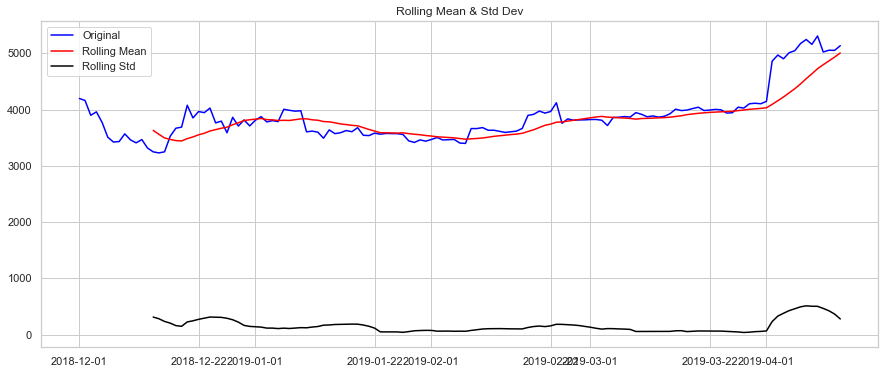

Dickey-Fuller Test Results:
Test Statistic                  -0.125278
p-value                          0.946862
Lags Used                        1.000000
Number of Observations Used    133.000000
Critical Value (1%)             -3.480500
Critical Value (5%)             -2.883528
Critical Value (10%)            -2.578496
dtype: float64


In [11]:
test_stationarity(ts['Price'])

# Making TS Stationary


## Estimating & Eliminating Trend


/Users/bowhead/opt/anaconda3/envs/p36l/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)


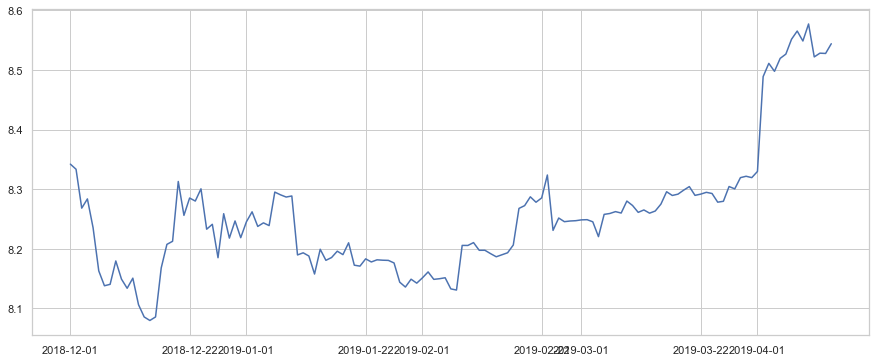

In [12]:
ts_log = np.log(ts)
plt.plot(ts_log)

## Smoothing:

### Moving average

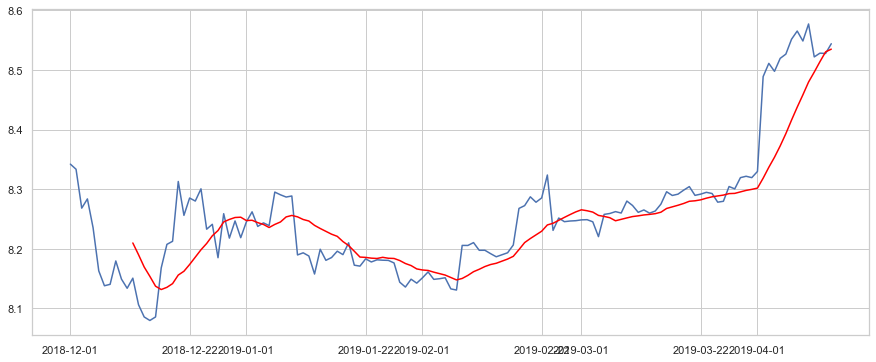

In [13]:
#moving_avg = pd.rolling_mean(ts_log,12)
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [14]:
ts_log_moving_avg_diff = ts_log - moving_avg
print(ts_log_moving_avg_diff.head(12))
ts_log_moving_avg_diff.dropna(inplace=True)
print(ts_log_moving_avg_diff.head())

               Price
Date                
2018-12-01       NaN
2018-12-02       NaN
2018-12-03       NaN
2018-12-04       NaN
2018-12-05       NaN
2018-12-06       NaN
2018-12-07       NaN
2018-12-08       NaN
2018-12-09       NaN
2018-12-10       NaN
2018-12-11       NaN
2018-12-12 -0.058978
               Price
Date                
2018-12-12 -0.058978
2018-12-13 -0.083824
2018-12-14 -0.083758
2018-12-15 -0.073962
2018-12-16 -0.051544


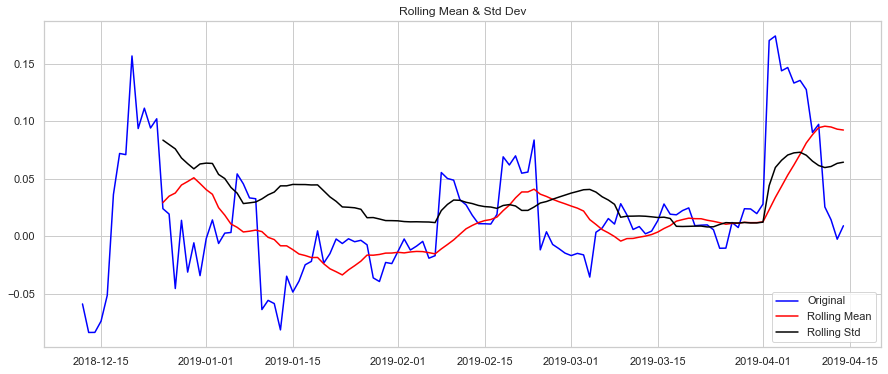

Dickey-Fuller Test Results:
Test Statistic                  -3.995684
p-value                          0.001433
Lags Used                        2.000000
Number of Observations Used    121.000000
Critical Value (1%)             -3.485585
Critical Value (5%)             -2.885739
Critical Value (10%)            -2.579676
dtype: float64


In [15]:
test_stationarity(ts_log_moving_avg_diff['Price'])

#### Exponentially Weighted Moving Average (EWMA)

In [28]:
#ts_log
#ts_log.ewm(halflife=12).mean()

,Price
Date,
2018-12-01,8.341935
2018-12-02,8.337527
2018-12-03,8.313060
2018-12-04,8.305050
2018-12-05,8.289434
2018-12-06,8.265201
2018-12-07,8.243741
2018-12-08,8.228072
2018-12-09,8.221364


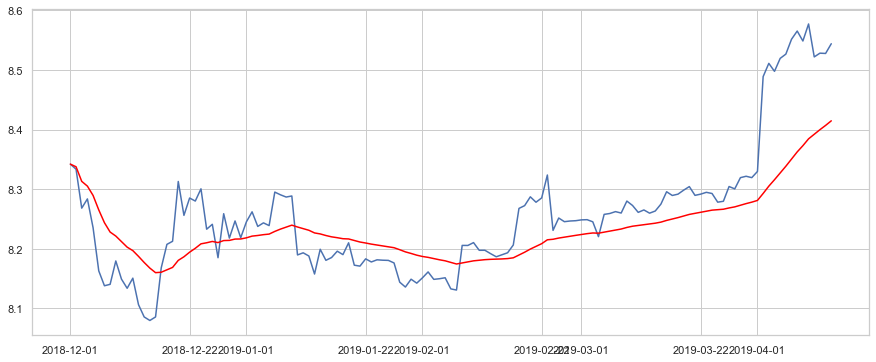

In [30]:
#import pdb; pdb.set_trace()
#expwighted_avg = pd.ewma(ts_log, halflife=12)
expwighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')
# expwighted_avg.plot(style='k--')

#expwighted_avg

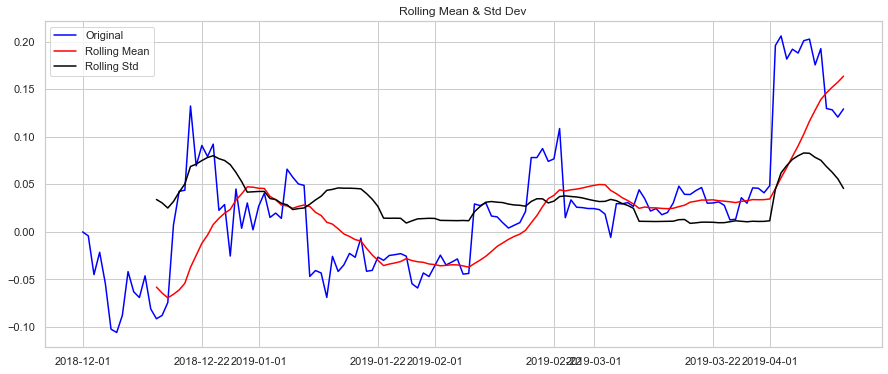

Dickey-Fuller Test Results:
Test Statistic                  -2.182975
p-value                          0.212483
Lags Used                        2.000000
Number of Observations Used    132.000000
Critical Value (1%)             -3.480888
Critical Value (5%)             -2.883697
Critical Value (10%)            -2.578586
dtype: float64


In [31]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff['Price'])

## Eliminating Trend & Seasonality

### Differencing:

/Users/bowhead/opt/anaconda3/envs/p36l/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)


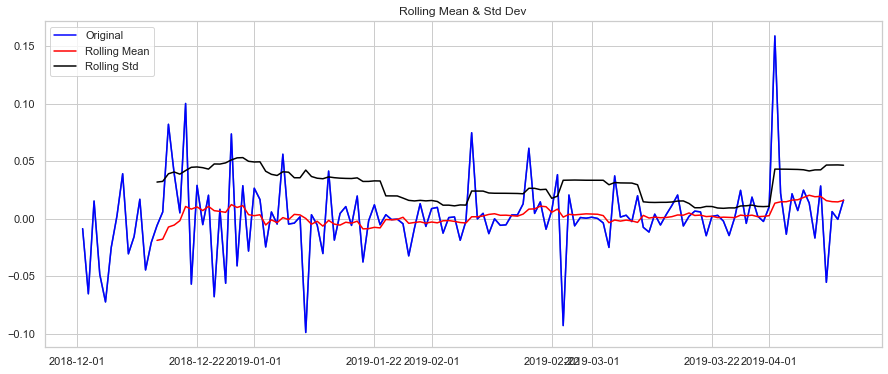

Dickey-Fuller Test Results:
Test Statistic                -1.318226e+01
p-value                        1.189434e-24
Lags Used                      0.000000e+00
Number of Observations Used    1.330000e+02
Critical Value (1%)           -3.480500e+00
Critical Value (5%)           -2.883528e+00
Critical Value (10%)          -2.578496e+00
dtype: float64


In [32]:
#Take first difference:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff['Price'])

### Decomposition:

/Users/bowhead/opt/anaconda3/envs/p36l/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)


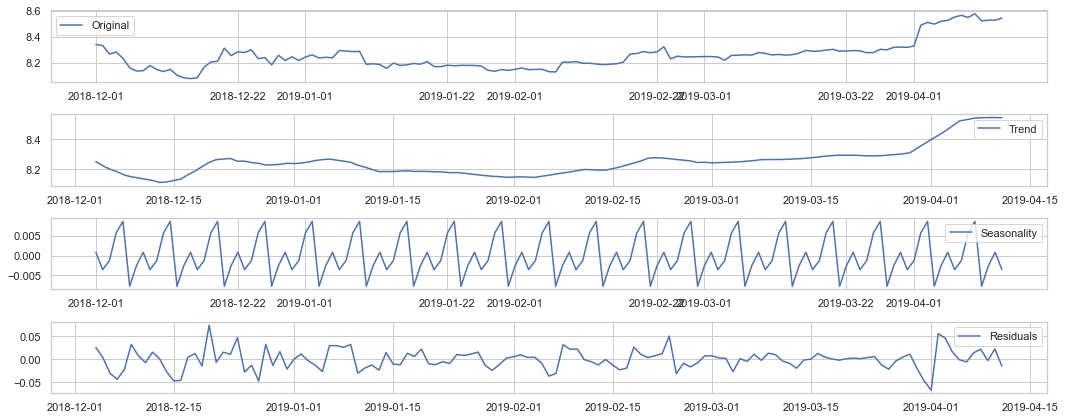

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [39]:
ts_log_decompose

Date
2018-12-04    0.025935
2018-12-05    0.003410
2018-12-06   -0.030348
2018-12-07   -0.043526
2018-12-08   -0.023152
2018-12-09    0.032538
2018-12-10    0.007872
2018-12-11   -0.007104
2018-12-12    0.015600
2018-12-13    0.001086
2018-12-14   -0.027411
2018-12-15   -0.047248
2018-12-16   -0.045714
2018-12-17    0.004651
2018-12-18    0.012699
2018-12-19   -0.014378
2018-12-20    0.074703
2018-12-21   -0.006294
2018-12-22    0.015696
2018-12-23    0.011002
2018-12-24    0.047455
2018-12-25   -0.027729
2018-12-26   -0.012818
2018-12-27   -0.047546
2018-12-28    0.032707
2018-12-29   -0.013399
2018-12-30    0.016823
2018-12-31   -0.021052
2019-01-01    0.000672
2019-01-02    0.011494
                ...   
2019-03-13   -0.019339
2019-03-14   -0.001588
2019-03-15    0.000420
2019-03-16    0.012965
2019-03-17    0.004801
2019-03-18    0.000924
2019-03-19   -0.001842
2019-03-20    0.001359
2019-03-21    0.002739
2019-03-22    0.001469
2019-03-23    0.003737
2019-03-24    0.006204
2019-0

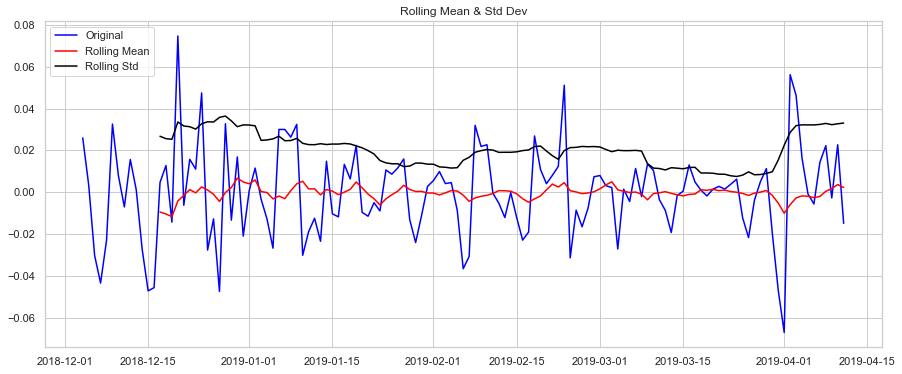

Dickey-Fuller Test Results:
Test Statistic                  -5.228957
p-value                          0.000008
Lags Used                        8.000000
Number of Observations Used    120.000000
Critical Value (1%)             -3.486056
Critical Value (5%)             -2.885943
Critical Value (10%)            -2.579785
dtype: float64


In [41]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

## Forecasting

#### ACF & PACF Plots

/Users/bowhead/opt/anaconda3/envs/p36l/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:669: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


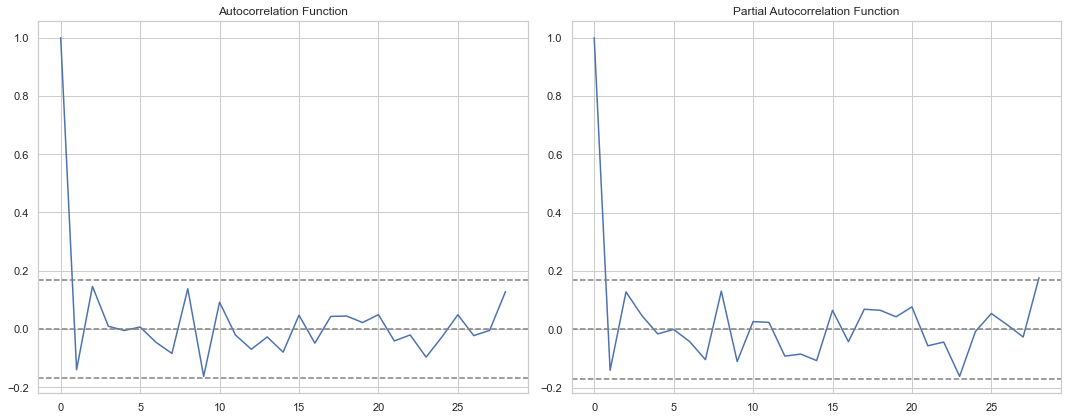

In [42]:
lag_acf = acf(ts_log_diff, nlags=28)
lag_pacf = pacf(ts_log_diff, nlags=28, method='ols')

#Plot ACF:    
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Do not read (pertains to non-differenced testing): The slow decay of the autocorrelation function suggests the data follow a long-memory process. 
The duration of shocks is relatively persistent and influence the data several observations ahead. 
This is probably reflected by a smooth trending pattern in the data.

### AR Model:

In [43]:
# from pmdarima import auto_arima
# stepwise_model = auto_arima(ts, start_p=1, start_q=1,max_p=3, max_q=3, m=12,
#                            start_P=0, seasonal=True,
#                            d=1, D=1, trace=True,
#                            error_action='ignore',  
#                            suppress_warnings=True)
# print(stepwise_model.aic())

In [44]:
# #RA model:
# model = ARIMA(ts_log, order=(2, 1, 0))  
# results_AR = model.fit(disp=-1)  
# plt.plot(ts_log_diff)
# plt.plot(results_AR.fittedvalues, color='red')
# plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

### MA Model

/Users/bowhead/opt/anaconda3/envs/p36l/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/bowhead/opt/anaconda3/envs/p36l/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency infor

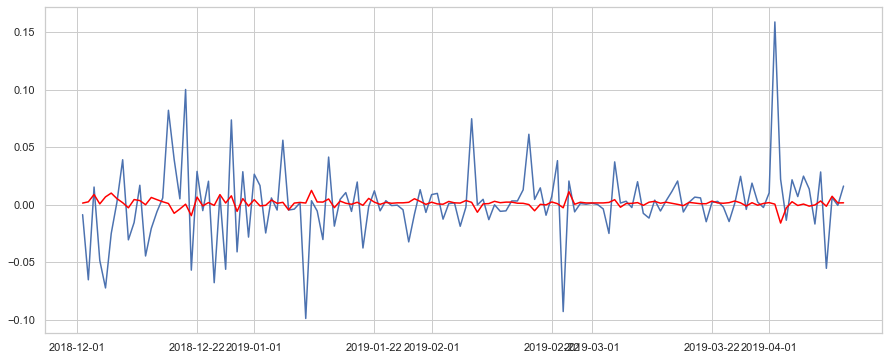

In [45]:
m1 = ARIMA(ts_log, order=(0, 1, 1))  
results_m1 = m1.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_m1.fittedvalues, color='red')
#plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))
print(results_m1)

### Convert to original scale:

In [46]:
predictions_m1_diff = pd.Series(results_m1.fittedvalues, copy=True)
print(predictions_m1_diff.head())
predictions_m1_diff_cumsum = predictions_m1_diff.cumsum()
print(predictions_m1_diff_cumsum.head())

Date
2018-12-02    0.001509
2018-12-03    0.002601
2018-12-04    0.008944
2018-12-05    0.000795
2018-12-06    0.006901
dtype: float64
Date
2018-12-02    0.001509
2018-12-03    0.004109
2018-12-04    0.013053
2018-12-05    0.013848
2018-12-06    0.020749
dtype: float64


In [47]:
predictions_m1_log = pd.DataFrame(ts_log.ix[0:])
predictions_m1_diff_cumsum = pd.DataFrame(predictions_m1_diff_cumsum)
print(predictions_m1_diff_cumsum.tail(2))
print(predictions_m1_log.tail(2))
predictions_m1_log['Price'] = predictions_m1_log['Price'] + predictions_m1_diff_cumsum[0]
print(predictions_m1_log.tail(2))

                   0
Date                
2019-04-13  0.202236
2019-04-14  0.203976
               Price
Date                
2019-04-13  8.527500
2019-04-14  8.543796
               Price
Date                
2019-04-13  8.729736
2019-04-14  8.747773


/Users/bowhead/opt/anaconda3/envs/p36l/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


[8.74768468 8.74919336 8.75070203 8.7522107  8.75371937 8.75522805
 8.75673672 8.75824539 8.75975406 8.76126274 8.76277141 8.76428008
 8.76578875 8.76729742]
[6498.71322672 6578.76902731 6645.07925146 6703.78081201 6757.48728329
 6807.60037184 6854.97498974 6900.17787398 6943.60747112 6985.55645852
 7026.24725279 7065.85352937 7104.5139498  7142.34128954]


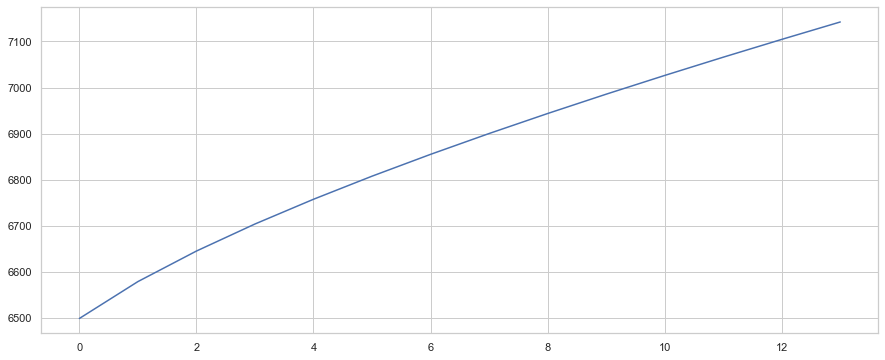

In [48]:
# multi-step out-of-sample forecast
forecast_m1 = results_m1.forecast(steps=14)[0]
print(forecast_m1)
predictions_m1 = np.exp(results_m1.forecast(steps=14)[0] + results_m1.forecast(steps=14)[1])
print(predictions_m1)
plt.plot(predictions_m1)

In [49]:
np.exp(predictions_m1_log).to_csv('arima011.csv')
pd.DataFrame(predictions_m1).to_csv('arima011pred.csv')

In [50]:
# sm1 = sm.tsa.statespace.SARIMAX(df.riders, trend='n', order=(0,1,0), seasonal_order=(1,1,1,12))

## VAR

In [51]:
print('\n Data Types:')
print(df.dtypes)
print(df.head(2))
print("")
print(len(df))


 Data Types:
Price           float64
Open            float64
High            float64
Low             float64
Vol2            float64
Change %         object
ARIMA(0,1,2)    float64
ARIMA(0,1,1)    float64
ARIMA(1,2,1)    float64
ARIMA(0,1,3)    float64
VAR(2)          float64
VAR(4)          float64
dtype: object
             Price   Open    High    Low     Vol2 Change %  ARIMA(0,1,2)  \
Date                                                                       
2017-01-01   995.4  963.4  1001.6  956.1  41150.0    3.33%           NaN   
2017-01-02  1017.0  995.4  1031.7  990.2  64950.0    2.17%           NaN   

            ARIMA(0,1,1)  ARIMA(1,2,1)  ARIMA(0,1,3)  VAR(2)  VAR(4)  
Date                                                                  
2017-01-01           NaN           NaN           NaN     NaN     NaN  
2017-01-02           NaN           NaN           NaN     NaN     NaN  

848


In [52]:
data = df
test = np.log(data['Price']).diff().dropna()
np.exp(test)

Date
2017-01-02    1.021700
2017-01-03    1.016028
2017-01-04    1.098810
2017-01-05    0.871323
2017-01-06    0.895785
2017-01-07    1.003047
2017-01-08    1.013500
2017-01-09    0.998779
2017-01-10    1.005112
2017-01-11    0.868421
2017-01-12    1.031449
2017-01-13    1.018146
2017-01-14    0.993695
2017-01-15    1.001952
2017-01-16    1.007428
2017-01-17    1.087514
2017-01-18    0.969212
2017-01-19    1.026606
2017-01-20    0.997431
2017-01-21    1.030127
2017-01-22    0.998913
2017-01-23    1.002939
2017-01-24    0.969940
2017-01-25    1.000671
2017-01-26    1.023703
2017-01-27    1.002621
2017-01-28    1.000545
2017-01-29    0.995645
2017-01-30    1.006780
2017-01-31    1.048659
                ...   
2019-03-16    1.020921
2019-03-17    0.993785
2019-03-18    1.002185
2019-03-19    1.006716
2019-03-20    1.006024
2019-03-21    0.985400
2019-03-22    1.002059
2019-03-23    1.003032
2019-03-24    0.998051
2019-03-25    0.985556
2019-03-26    1.001473
2019-03-27    1.025084
2019-0

In [54]:
data

,Price,Open,High,Low,Vol2,Change %,"ARIMA(0,1,2)","ARIMA(0,1,1)","ARIMA(1,2,1)","ARIMA(0,1,3)",VAR(2),VAR(4)
Date,,,,,,,,,,,,
2017-01-01,995.4,963.4,1001.6,956.1,41150.0,3.33%,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,1017.0,995.4,1031.7,990.2,64950.0,2.17%,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,1033.3,1017.0,1035.5,1006.5,54790.0,1.60%,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,1135.4,1033.3,1148.5,1022.3,156270.0,9.88%,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,989.3,1135.4,1150.6,874.5,240010.0,-12.86%,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,886.2,989.3,1027.4,852.5,194290.0,-10.43%,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-07,888.9,886.2,900.9,806.7,130660.0,0.31%,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-08,900.9,888.9,936.1,875.8,76910.0,1.35%,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-09,899.8,900.9,910.5,870.9,62580.0,-0.12%,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
var1 = VAR(data[['Price', 'Open', 'High', 'Low']])
var_fit1 = var1.fit(1)
var_fit2 = var1.fit(2) #Best, but needs a restricted functrion, not available in python. Lag 4 High is interesting
var_fit3 = var1.fit(3)
var_fit4 = var1.fit(4)

/Users/bowhead/opt/anaconda3/envs/p36l/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


LinAlgError: SVD did not converge in Linear Least Squares

In [ ]:
var_fit2.summary()

In [ ]:
# make prediction
yhat = var_fit4.forecast(var_fit4.y, steps=14)
print(yhat)